In [ ]:
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import glob
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'Number_Data.zip',
      origin="https://dl.dropboxusercontent.com/s/72974nnbp1osymg/Number_Data.zip?dl=0",
      extract=True,
      cache_dir='.', cache_subdir='data')

893901873/893901873 [==============================] - 12s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
num_labels= len(commands)
print ('Labels: ',num_labels)
print('Number:', commands)

Labels:  10
Number: ['six' 'five' 'eight' 'one' 'seven' 'nine' 'four' 'two' 'zero' 'three']


In [ ]:
def generate_csv(folder, label):
    folder_name = os.path.basename(folder)
    labels = list(label)
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath,label]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

dir_folder = 'data/mini_speech_commands'
generate_csv(dir_folder, {'zero','one','two','three','four','five','six','seven','eight','nine'})

Saving mini_speech_commands.csv


In [ ]:
number_data = "mini_speech_commands.csv"
number_data = pd.read_csv(number_data)
number_data.tail()

,Unnamed: 0,filepath,label
38903,38903,data/mini_speech_commands/six/cce7416f_nohash_...,six
38904,38904,data/mini_speech_commands/six/ca4912b6_nohash_...,six
38905,38905,data/mini_speech_commands/six/876c84d6_nohash_...,six
38906,38906,data/mini_speech_commands/six/779de043_nohash_...,six
38907,38907,data/mini_speech_commands/six/feb1d305_nohash_...,six


In [ ]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs = np.zeros((13,44))
    mfccs[:mfcc.shape[0], :mfcc.shape[1]]=mfcc
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

    return mfccs_features

In [ ]:
extracted_mfccs=[]
for index_num,row in tqdm(number_data.iterrows()):
    filename = str(row["filepath"])
    class_labels=row["label"]
    data=features_extractor(filename)
    extracted_mfccs.append([data,class_labels])

38908it [10:39, 60.81it/s]


In [ ]:
extracted_features_df=pd.DataFrame(extracted_mfccs,columns=['feature','label'])
extracted_features_df.tail()

,feature,label
38903,"[[-613.0975341796875, -376.6209411621094, -290...",six
38904,"[[-672.01904296875, -668.9650268554688, -669.4...",six
38905,"[[-506.1437072753906, -513.0045166015625, -522...",six
38906,"[[-530.0039672851562, -508.61676025390625, -49...",six
38907,"[[-454.74456787109375, -433.4952087402344, -42...",six


In [ ]:
extracted_features_df['feature'][0].shape

(39, 44)

In [ ]:
x_data = np.stack(extracted_features_df['feature'])
y_data =np.array(extracted_features_df['label'].tolist())
x_data.shape

(38908, 39, 44)

In [ ]:
labelencoder=LabelEncoder()
y_encoder=to_categorical(labelencoder.fit_transform(y_data))
x = 2836
print(y_data[x])
print(y_encoder[x])

one
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
def split_data(x_data, y_data, test_size=0.1, valid_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=5)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=5)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }
data = split_data(x_data, y_encoder, test_size=0.1, valid_size=0.1)

In [ ]:
data["X_train"].shape

(31515, 39, 44)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(39,44)))
model.add(Dense(256,activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(num_labels,activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1716)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               439552    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
    )

In [ ]:

batch_size = 128
epochs = 100
# train the model using the training set and validating using validation set
history = model.fit(
    data["X_train"], data["y_train"],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/100
247/247 [==============================] - 6s 18ms/step - loss: 2.7732 - accuracy: 0.1051 - val_loss: 2.3027 - val_accuracy: 0.1054
Epoch 2/100
247/247 [==============================] - 5s 21ms/step - loss: 2.2381 - accuracy: 0.1463 - val_loss: 2.1580 - val_accuracy: 0.1770
Epoch 3/100
247/247 [==============================] - 4s 16ms/step - loss: 2.1358 - accuracy: 0.1851 - val_loss: 2.0180 - val_accuracy: 0.2638
Epoch 4/100
247/247 [==============================] - 4s 17ms/step - loss: 1.8030 - accuracy: 0.3519 - val_loss: 1.3365 - val_accuracy: 0.5109
Epoch 5/100
247/247 [==============================] - 5s 21ms/step - loss: 1.3917 - accuracy: 0.4871 - val_loss: 1.0715 - val_accuracy: 0.6174
Epoch 6/100
247/247 [==============================] - 4s 16ms/step - loss: 1.1418 - accuracy: 0.5904 - val_loss: 0.8247 - val_accuracy: 0.7110
Epoch 7/100
247/247 [==============================] - 4s 17ms/step - loss: 0.9823 - accuracy: 0.6626 - val_loss: 0.7657 - val_accuracy:

In [ ]:
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 3891 samples...
Loss: 0.3638
Accuracy: 89.69%


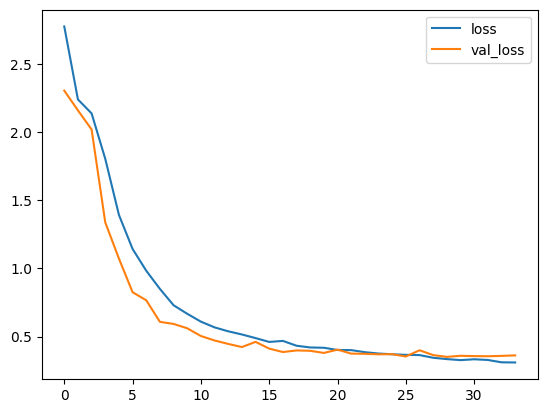

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
file_test = data_dir/'zero/004ae714_nohash_0.wav'
feature = features_extractor(file_test).reshape(1,39,44)
y_predict=model.predict(feature)

1/1 [==============================] - 0s 145ms/step


In [ ]:
s = np.argmax(y_predict[0])
match s:
  case 0:
    print("eight")
  case 1:
    print("five")
  case 2:
    print("four")
  case 3:
    print("nine")
  case 4:
    print("one")
  case 5:
    print("seven")
  case 6:
    print("six")
  case 7:
    print("three")
  case 8:
    print("two")
  case 9:
    print("zero")

zero
